In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
df=pd.read_csv('Breast Cancer Wisconsin (Diagnostic) Data.csv')

In [3]:
# catogorical column - Diagnosis (M = malignant =1 , B = benign=0)
df['target']=df['diagnosis'].map({"M":1,"B":0})

In [4]:
# Drop diagnosis column
df.drop(columns='diagnosis',inplace=True)

In [8]:
# declare inputs and target
inputs=df.drop(columns=['id','target','Unnamed: 32'])
target=df.target

In [30]:
# Import the module for the split
from sklearn.model_selection import train_test_split

# Split the variables with an 80-20 split and some random state
# To have the same split as mine, use random_state = 365
x_train, x_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2, random_state=365)

#check the shape of the results
print("Training set - Features: ", x_train.shape, "Target: ", y_train.shape)
print("Test set- Features: ", x_test.shape, "Target: ",y_test.shape)

Training set - Features:  (455, 30) Target:  (455,)
Test set- Features:  (114, 30) Target:  (114,)


In [31]:
#Data standardization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  
scaler.fit(x_train)

x_train = scaler.transform(x_train)  
x_test = scaler.transform(x_test)

In [32]:
 # PCA transformation and reduce the dimension
from sklearn.decomposition import PCA

In [33]:
# create a function to plot line graph to compare ratio - Explained Variance changes with different n component
def EV(n):
    pca = PCA(n_components=n, whiten=True)
    X_train = pca.fit_transform(x_train)
    X_test = pca.transform(x_test)
    #plot
    plt.plot(range(1,int(n+1)), pca.explained_variance_ratio_.cumsum())
    plt.title('Explained Variance',fontsize=15)
    plt.xlabel('Number of Principle Components : {}'.format(n), fontsize=10)

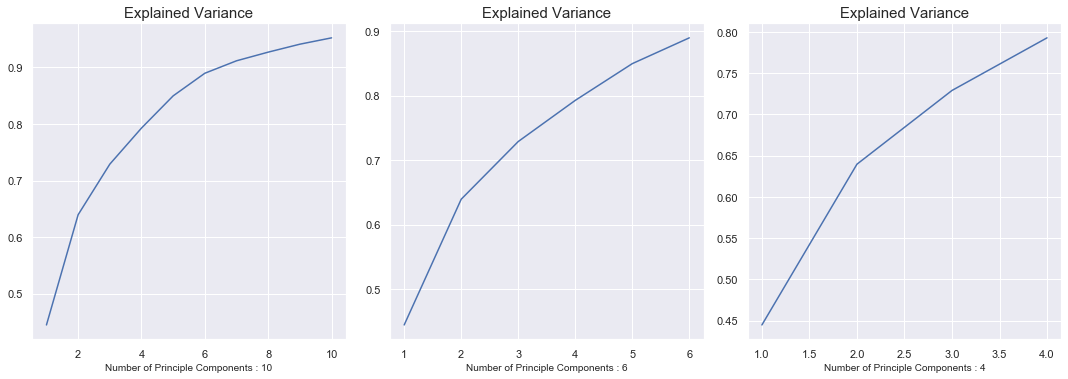

In [34]:
# use the function above and try use n_component from 15-19
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
EV(10)
plt.subplot(2,3,2)
EV(6)
plt.subplot(2,3,3)
EV(4)
plt.tight_layout()

***We can see that the ratio increased a lot when changes of n_components are from 15 to 19 dimensions, which means when data is compressed into 3 number of dimensions, those dimensions can capture 99% of the overall variance.Briefly speaking, our inputs data has 30 dimensions and if we compress the inputs data into 16 dimensions, we still can obtain the most information from inputs data. Using this visualization method can help us to choose the number of components better.***

In [35]:
# PCA transformation and reduce the dimension from 4096 to 50
pca = PCA(n_components=3, whiten=True)
X_train = pca.fit_transform(x_train)
X_test = pca.transform(x_test)

# Machine Learning Application

## Random Forest 

In [36]:
#GridSearch
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

# given prameters different values
# given prameters different values
random_grid={
             'n_estimators':list(range(220,240)),
             'max_depth':list(range(1,30,2)),
             'max_features':list(range(1,19)),
             'min_samples_leaf':list(range(1,19)),
             'min_samples_split':list(range(1,19))                   
                            
                                
            }

In [37]:
# random forest model
rfc=RandomForestClassifier(random_state=666)
# randommized searchCV
RS=RandomizedSearchCV(rfc,random_grid,cv=10)

In [38]:
# fit the train data
RS.fit(X_train,y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
              

In [39]:
RS.best_params_,RS.best_score_

({'n_estimators': 229,
  'min_samples_split': 10,
  'min_samples_leaf': 2,
  'max_features': 3,
  'max_depth': 13},
 0.9318357487922706)

In [46]:
# Random Forest model with best parameters
rfc=RandomForestClassifier(
    n_estimators=RS.best_params_["n_estimators"],
 min_samples_split= RS.best_params_["min_samples_split"],
 min_samples_leaf= RS.best_params_["min_samples_leaf"],
 max_features= RS.best_params_["max_features"],
 max_depth= RS.best_params_["max_depth"],
 n_jobs=-1,
 random_state=42)

In [47]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=229,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [48]:
# let us take a look at the results
print('Accuracy score of train data :{}'.format(rfc.score(X_train,y_train)))
print('Accuracy score of test data:{}'.format(rfc.score(X_test,y_test)))
# obtian train data f1_Score
pre_train=rfc.predict(X_train)
print('Train data f1_Score:{}'.format(f1_score(y_train, pre_train,average='weighted')))
# Obtain Test data f1_Score
y_pred=rfc.predict(X_test)
print('Test data f1_Score:{}'.format(f1_score(y_test, y_pred,average='weighted')))

Accuracy score of train data :0.978021978021978
Accuracy score of test data:0.956140350877193
Train data f1_Score:0.9779927347817717
Test data f1_Score:0.9560669894569158


In [50]:
 # function of  plot_confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[65  2]
 [ 3 44]]


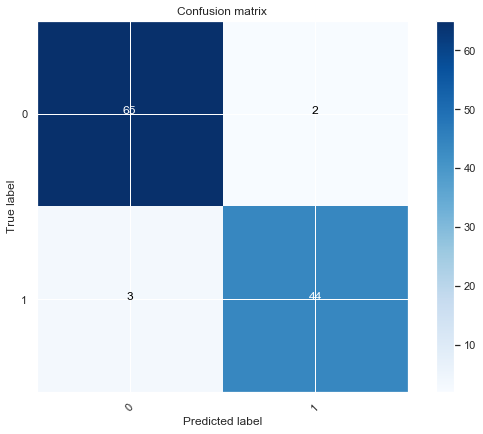

In [52]:
from sklearn import metrics
classes = ['0','1']
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

## K-Nearest Neighbors

In [61]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

In [62]:
random_gridknn={'n_neighbors':[1,100,200]}
knn= KNeighborsClassifier()
gs_knn=GridSearchCV(knn,random_gridknn,cv=10)
gs_knn.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 100, 200]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [63]:
gs_knn.best_params_,gs_knn.best_score_


({'n_neighbors': 1}, 0.9317391304347826)

In [64]:
#Final KNN model

In [65]:
knn_final= KNeighborsClassifier(n_neighbors=1)
knn_final.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [66]:
y_train_pre=knn_final.predict(X_train)

print('accuracy_score of train data :{}'.format (accuracy_score(y_train,y_train_pre)))
print('f1_score of train data:{}'.format(f1_score(y_train,y_train_pre,average='macro'))) 
# # make class predictions for the testing set

y_pred_class = knn_final.predict(X_test)
print('accuracy_score of test data :{}'.format (accuracy_score(y_test, y_pred_class)))
print('f1_score of test data:{}'.format(f1_score(y_test, y_pred_class,average='macro')) )

accuracy_score of train data :1.0
f1_score of train data:1.0
accuracy_score of test data :0.9210526315789473
f1_score of test data:0.9177027352209834
